# Introduction to single-cell Variational Inference (scVI)
In this introductory tutorial, we go through the different steps of a scVI workflow
1. Loading the data
2. Training the model
3. Retrieving the latent space and imputed values
4. Visualize the latent space with scanpy
5. Perform differential expression 
6. The special case of scVI for batch effect correction
7. Miscenalleous information

In [3]:
%matplotlib inline

In [6]:
!which jupyter
import sys
!conda list | grep scvi

/home/alaridl/anaconda3/envs/scvienv/bin/jupyter
# packages in environment at /home/alaridl/anaconda3/envs/scvienv:
scvi                      0.2.4                    pypi_0    pypi


In [1]:
def allow_notebook_for_test():
    print("Testing the basic tutorial notebook")

import scvi
test_mode = False
save_path = "data/"
n_epochs_all = None
show_plot = True

if not test_mode:
    save_path = "../../data"

[2019-12-14 10:11:47,805] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.


In [2]:
!conda list | grep numpy

numpy                     1.17.3           py37h95a1406_0    conda-forge


In [3]:
#!pip install scvi

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scvi.dataset import CortexDataset, RetinaDataset
from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer
import torch

/home/alaridl/anaconda3/envs/scvi_clean/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


## Loading data

Let us first load the CORTEX dataset described in Zeisel et al. (2015). scVI has many "built-in" datasets as well as support for loading arbitrary .csv, .loom, and .h5ad (AnnData) files. Please see our [data loading Jupyter notebook](https://github.com/YosefLab/scVI/blob/master/tests/notebooks/data_loading.ipynb) for more examples of data loading.

* Zeisel, Amit, et al. "Cell types in the mouse cortex and hippocampus revealed by single-cell RNA-seq." Science 347.6226 (2015): 1138-1142. 

In [5]:
gene_dataset = CortexDataset(save_path=save_path, total_genes=558)

[2019-12-14 10:12:02,646] INFO - scvi.dataset.dataset | File /home/alaridl/pCloudDrive/W/dl_projects_combined/Modules/2_vi_scvi/scvi_work_here/data/expression.bin already downloaded
[2019-12-14 10:12:02,647] INFO - scvi.dataset.cortex | Loading Cortex data
[2019-12-14 10:12:16,111] INFO - scvi.dataset.cortex | Finished preprocessing Cortex data
[2019-12-14 10:12:16,120] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-12-14 10:12:16,122] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]


In this demonstration and for this particular dataset, we use only 558 genes as in the original scVI publication. This was essentially for benchmarking purposes and we propose here a few practical rules for gene filtering with scVI:
+ If many cells are available, it is in general better to use as many genes as possible. Of course, it might be of interest to remove ad-hoc genes depending on the downstream analysis or the application. 
+ When the dataset is small, it is usually better to filter out genes to avoid overfitting. In the original scVI publication, we reported poor imputation performance for when the number of cells was lower than the number of genes. This is all empirical and in general, it is hard to predict what the optimal number of genes will be.
+ The default scVI code will filter genes based on variance. We advise relying on scanpy and then importing the **unnormalized** filtered matrix into scVI for more complex filtering schemes. 

## Training

* __n_epochs__: Maximum number of epochs to train the model. If the likelihood change is small than a set threshold training will stop automatically. 
* __lr__: learning rate. Set to 0.001 here. 
* __use_batches__: If the value of true than batch information is used in the training. Here it is set to false because the cortex data only contains one batch. 
* __use_cuda__: Set to true to use CUDA (GPU required) 


In [6]:
n_epochs = 100 if n_epochs_all is None else n_epochs_all
lr = 1e-3
use_batches = False
use_cuda = True

We now create the model and the trainer object. We train the model and output model likelihood every 5 epochs. In order to evaluate the likelihood on a test set, we split the datasets (the current code can also so train/validation/test).

If a pre-trained model already exist in the save_path then load the same model rather than re-training it. This is particularly useful for large datasets.

In [7]:
gene_dataset

GeneExpressionDataset object with n_cells x nb_genes = 3005 x 558
    gene_attribute_names: 'gene_names'
    cell_attribute_names: 'local_means', 'local_vars', 'labels', 'batch_indices', 'precise_labels'
    cell_categorical_attribute_names: 'labels', 'batch_indices'

In [11]:

vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches * use_batches)
trainer = UnsupervisedTrainer(
    vae,
    gene_dataset,
    train_size=0.75,
    use_cuda=use_cuda,,
    frequency=5,
)

if os.path.isfile('%s/vae.pkl' % save_path):
    trainer.model.load_state_dict(torch.load('%s/vae.pkl' % save_path))
    trainer.model.eval()
else:
    trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(trainer.model.state_dict(), '%s/vae.pkl' % save_path)

training: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


**Plotting the likelihood change across the 500 epochs of training: blue for training error and orange for testing error.**

(1150, 1600)

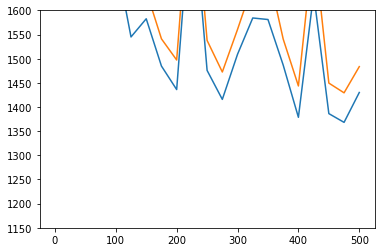

In [12]:
elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]
x = np.linspace(0, 500, (len(elbo_train_set)))
plt.plot(x, elbo_train_set)
plt.plot(x, elbo_test_set)
plt.ylim(1150, 1600)

## Obtaining the posterior object and sample latent space as well as imputation from it

The posterior object contains a model and a gene_dataset, as well as additional arguments that for Pytorch's `DataLoader`. It also comes with many methods or utilities querying the model, such as differential expression, imputation and differential analyisis.


To get an ordered output result, we might use `.sequential` posterior's method which return another instance of posterior (with shallow copy of all its object references), but where the iteration is in the same ordered as its  indices attribute.

In [14]:
full = trainer.create_posterior(trainer.model, gene_dataset, indices=np.arange(len(gene_dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()

Similarly, it is possible to query the imputed values via the `imputation` method of the posterior object. **Note for advanced users:** imputation is an ambiguous term and there are two ways to perform imputation in scVI. The first way is to query the **mean of the negative binomial** distribution modeling the counts. This is referred to as `sample_rate` in the codebase and can be reached via the `imputation` method. The second is to query the **normalized mean of the same negative binomial** (please refer to the scVI manuscript). This is referred to as `sample_scale` in the codebase and can be reached via the `get_sample_scale` method. In differential expression for example, we of course rely on the normalized latent variable which is corrected for variations in sequencing depth.

In [15]:
imputed_values = full.sequential().imputation()
normalized_values = full.sequential().get_sample_scale()

## Visualizing the latent space with scanpy

scanpy is a handy and powerful python library for visualization and downstream analysis of single-cell RNA sequencing data. We show here how to feed the latent space of scVI into a scanpy object and visualize it using UMAP as implemented in scanpy. More on how scVI can be used with scanpy on [this notebook](https://github.com/YosefLab/scVI/blob/master/tests/notebooks/scanpy_pbmc3k.ipynb). **Note to advanced users:** The code 'get_latent' returns only the mean of the posterior distribution for the latent space. However, we recover a full distribution with our inference framework. Let us keep in mind that the latent space visualized here is a practical summary of the data only. Uncertainty is needed for other downstream analyses such as differential expression. 

In [11]:
import scanpy as sc
import anndata

In [12]:
post_adata = anndata.AnnData(X=gene_dataset.X)
post_adata.obsm["X_scVI"] = latent
post_adata.obs['cell_type'] = np.array([gene_dataset.cell_types[gene_dataset.labels[i][0]]  
                                        for i in range(post_adata.n_obs)])
sc.pp.neighbors(post_adata, use_rep="X_scVI", n_neighbors=15)
sc.tl.umap(post_adata, min_dist=0.1)

... storing 'cell_type' as categorical


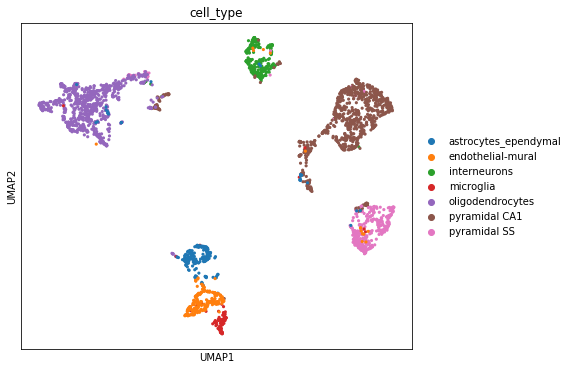

In [13]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["cell_type"], ax=ax, show=show_plot)

The user will note that we imported curated labels from the original publication. Our interface with scanpy makes it easy to cluster the data with scanpy from scVI's latent space and then reinject them into scVI for differential expression, which we now discuss.

In [ ]:
## 

# From Understanding to Applications of SCVI

## 

## Towards Understanding Differential Expression : Bayes Factor

## Understanding Code for Differential Expression : POSTERIOR OBJECT

### Understanding Posterior Initialize Method

In [22]:
GeneExpressionDataset = gene_dataset  # setting GeneExpressionDataset to None so that you can execute the cell
model = vae # setting model to None so that you can execute the cell
def __init__(
    self,
    model,
    gene_dataset: GeneExpressionDataset,
    shuffle=False,
    indices=None,
    use_cuda=True,
    data_loader_kwargs=dict(),
):

    """
    When added to annotation, has a private name attribute
    """

    self.model = model
    self.gene_dataset = gene_dataset
    self.to_monitor = []
    self.use_cuda = use_cuda


Every new class' constructor in Python starts with __init__ that initializes the class in a way that when creating the object from the class, gives the object access to the input variables, in this case `model`, `gene_dataset` etc.
The colon after `gene_dataset` refers to the default type of Gene Dataset which is `GeneExpressionDataset`, which is a module of `scvi.dataset`.
The posterior object may also make use of additional keyword arguments passed to the data loader, and these are initialized to be an empty dictionary at object creation time.
`Model`, `gene_dataset`, `cuda` arguments are saved to internal states of the `Posterior` object and `to_monitor` is initialized to an empty list.



In [69]:
!pwd
import os
os.chdir("/home/alaridl/pCloudDrive/W/dl_projects_combined/Modules/2_vi_scvi/")
import sys
sys.path.append("/home/alari/pCloudDrive/W/dl_projects_combined/Modules/2_vi_scvi/")
import scvi


/home/alaridl/pCloudDrive/W/dl_projects_combined/Modules/2_vi_scvi


The beginning of the class looks like the following:

In [74]:
class Posterior:
    def __init__(
        self,
        model,
        gene_dataset: GeneExpressionDataset,
        shuffle=False,
        indices=None,
        use_cuda=True,
        data_loader_kwargs=dict(),
    ):
        """

        When added to annotation, has a private name attribute
        """
        self.model = model
        self.gene_dataset = gene_dataset
        self.to_monitor = []
        self.use_cuda = use_cuda

        if indices is not None and shuffle:
            raise ValueError("indices is mutually exclusive with shuffle")
        if indices is None:
            if shuffle:
                sampler = RandomSampler(gene_dataset)
            else:
                sampler = SequentialSampler(gene_dataset)
        else:
            if hasattr(indices, "dtype") and indices.dtype is np.dtype("bool"):
                indices = np.where(indices)[0].ravel()
            sampler = SubsetRandomSampler(indices)
        self.data_loader_kwargs = copy.copy(data_loader_kwargs)
        self.data_loader_kwargs.update(
            {"collate_fn": gene_dataset.collate_fn_builder(), "sampler": sampler}
        )
        self.data_loader = DataLoader(gene_dataset, **self.data_loader_kwargs)


If user provides what indices to use in the posterior, then the data cannot be shuffled, this is what the first exception is for; otherwise if user does not provide indices (i.e. they are none, their default value), then a sampler is used for shuffling the data.

By analyzing the `posterior.py` file carefully, we notice that all these samplers are Pytorch modules, as defined by

```python
from torch.utils.data.sampler import (
    SequentialSampler,
    SubsetRandomSampler,
    RandomSampler,
)
```

If the user has provided indices for the Posterior object, then the `hasattr` method checks whether the indices have a `dtype` attribute. The `dtype` attribute is present whenever the indices is a Numpy array. Let's verify this.

In [76]:
import numpy as np
b = [1,2,3]
a = np.array(b)

if hasattr(a,"dtype"):
    print("A generic numpy array has dtype attribute")
else :
       print("A generic numpy array does not have  dtype attribute")
        
if hasattr(b,"dtype"):
    print("Python list has dtype attribute")
else :
       print("Python list does not have  dtype attribute")

A generic numpy array has dtype attribute
Python list does not have  dtype attribute


So we see indeed that Numpy arrays have `dtype` attribute while Python lists don't. Next the method checks whether the dtype is `bool`, meaning `True` or `False`. If so, then numpy's `where` method  is used to find the `True` indices and flatten the resulting array.

In [86]:
indices = np.array([True,False,True,False])
if hasattr(indices, "dtype") and indices.dtype is np.dtype("bool"):
    print("The constructed boolean array has correct format for the method")
    indices = np.where(indices)[0].ravel()
    print(f"Now the indices look like {indices}, since \n \
          ravel where extracts the True indices and ravel flattens the Numpy array, \n \
          causing it to be 1-dimensional")
else :
    print("The constructed boolean array does not have  correct format for the method")
#indices = np.where(indices)[0].ravel()


The constructed boolean array has correct format for the method
Now the indices look like [0 2], since 
           ravel where extracts the True indices and ravel flattens the Numpy array, 
           causing it to be 1-dimensional


Note that whereas Python lists don't have an inbuilt flatten method, but when using Numpy arrays, we will be equipped with the `ravel` method. Numpy arrays are also optimized for computing operations, making numerical calculations faster.

Nex the sampler is defined using `SubsetRandomSampler` from Pytorch. By going to [the source code](https://pytorch.org/docs/stable/_modules/torch/utils/data/sampler.html#SubsetRandomSampler), we see that
>> `SubsetRandomSampler` Samples elements randomly from a given list of indices, without replacement.

Internally it means that the `__iter__` method is defined as to make the `sampler` object iterable.

```python
(self.indices[i] for i in torch.randperm(len(self.indices)))
```
This means that the indices are randomly permuted and once an index has been selected, it cannot be selected again, since the sampling is without replacement.


Next we see an interesting `copy.copy()` construct. What could that mean?

By going to [Python manual page for that submodule](https://docs.python.org/3/library/copy.html)
, we can see the following:
    
> Assignment statements in Python do not copy objects, they create bindings between a target and an object. For collections that are mutable or contain mutable items, a copy is sometimes needed so one can change one copy without changing the other. This module provides generic shallow and deep copy operations (explained below).

```python
copy.copy(x)
```
Return a shallow copy of x.
In this case, the idea is to copy the `data_loader_kwargs` to the internal (or `self`) state of the `Posterior` object. If `data_loader_kwargs` are changed, then since the code

```python
self.data_loader_kwargs = copy.copy(data_loader_kwargs)
```
only uses a shallow copy to the kwargs, the internal state in Posterior is not changed.

#### Collate function for `Posterior`

```python
self.data_loader_kwargs.update(
            {"collate_fn": gene_dataset.collate_fn_builder(), "sampler": sampler}
        )
```

Can you guess what is the role of the previous code chunk?
Every dictionary in Python has an `update` method. Let's verify this


In [97]:
k = dict()
if hasattr(k,"items"):
    print("A generic dictionary in Python has items attribute")
if hasattr(k,"update"):
    print("A generic dictionary in Python has update attribute")
 
    

A generic dictionary in Python has items attribute
A generic dictionary in Python has update attribute


<function dict.items>

So we can see that we can also check the presence of methods with the `hasattr` function and the same way every dictionary in Python has `items`, it also has an `update` method to update items (i.e. to change or add items in the dictionary).


 In this case, the previously discussed sampler is saved and and a gene datasets
`collate_fn_builder` is called. Let's analyze what this method does. 
 
```python
def collate_fn_base(
    self, attributes_and_types: Dict[str, type], batch: Union[List[int], np.ndarray]
) -> Tuple[torch.Tensor, ...]:
    """Given indices and attributes to batch, returns a full batch of ``Torch.Tensor``"""
    indices = np.asarray(batch)
    data_numpy = [
        getattr(self, attr)[indices].astype(dtype)
        if isinstance(getattr(self, attr), np.ndarray)
        else getattr(self, attr)[indices].toarray().astype(dtype)
        for attr, dtype in attributes_and_types.items()
    ]

    data_torch = tuple(torch.from_numpy(d) for d in data_numpy)
    return data_torch

```



First we might notice constructs like Dict, Union, List, Tuple.
What are these?
When we browser the code for `dataset.py`, we can notice the following import
```python
from typing import Dict, Iterable, List, Tuple, Union, Optional, Callable
```


That means that from `typing` module we have imported the mentioned set of submodules.
[This Stackoverflow topic](https://stackoverflow.com/questions/32557920/what-are-type-hints-in-python-3-5) explains well why these type hint constructs exist:

> Due to the dynamic nature of Python, inferring or checking the type of an object being used is especially hard. This fact makes it hard for developers to understand what exactly is going on in code they haven't written and, most importantly, for type checking tools found in many IDEs [PyCharm, PyDev come to mind] that are limited due to the fact that they don't have any indicator of what type the objects are. As a result they resort to trying to infer the type with (as mentioned in the presentation) around 50% success rate.

Thus we can use the explicit constructs that denote the respective data types in Python.

Let's take a look at an example

In [ ]:
movie = {'name': 'Blade Runner',
         'year': 1982}

import typing
from typing import TypedDict

class Movie(TypedDict):
    name: str
    year: int

movie: Movie = {'name': 'Blade Runner',
                'year': 1982}
#That quantifies that now the object movie is of Movie type.

#### Collate Function Base

```python
def collate_fn_base(
    self, attributes_and_types: Dict[str, type], batch: Union[List[int], np.ndarray]
    ) -> Tuple[torch.Tensor, ...]:
```
This construct means that the base collate function takes in two arguments(`attributes_and_types`and `batch`)
and returns a Tuple of `torch.tensor` types.
The `attributes_and_types` Dictionary has both `str` and `type`. What are these? Since a dictionary is of `Mapping`, it specifies the data types of both the key and the value. For more information and examples, refer to [this source](https://mypy.readthedocs.io/en/latest/cheat_sheet_py3.html).
Batch is defined as a `Union` of an integer list and `numpy ndarray`.

```python
 """Given indices and attributes to batch, returns a full batch of ``Torch.Tensor``"""
    indices = np.asarray(batch)
    data_numpy = [
        getattr(self, attr)[indices].astype(dtype)
        if isinstance(getattr(self, attr), np.ndarray)
        else getattr(self, attr)[indices].toarray().astype(dtype)
        for attr, dtype in attributes_and_types.items()
    ]

    data_torch = tuple(torch.from_numpy(d) for d in data_numpy)
    return data_torch
```   
Firstly, the batch that was a `Union` of `List` and `ndarray` is converted into a `numpy array`. Then the `attributes_and_types` dictionary, that has all the attributes and their types, is looped over. If the attribute is of `ndarray` type then the attribute (any of
 > ("dataset_versions",
"gene_attribute_names",
"cell_attribute_names",
"cell_categorical_attribute_names",
"cell_measurements_columns") 

 or
 
> ("X", 
"corrupted_X",
"local_means",
"local_vars",
"batch_indices",
"labels")


of the respective indices are selected and converted to the defined `dtype`, otherwise if the attribute is not of `ndarray` type, then it is first converted to `ndarray` type and then converted, the resulting variable is called `data_numpy`.

Lastly, the following Python code converts the `data_numpy` to tuple of Torch Tensors, where each Tensor contains a list of defined attribute values. As the documentation specifies, the one return statement corresponds to one `batch` of data (not the whole dataset).

Thus the `collate_fn_base` is concluded and we can start analyzing the `collate_fn_builder`

```python
def collate_fn_builder(
    self,
    add_attributes_and_types: Dict[str, type] = None,
    override: bool = False,
    corrupted=False,
) -> Callable[[Union[List[int], np.ndarray]], Tuple[torch.Tensor, ...]]:
    """Returns a collate_fn with the requested shape/attributes"""

    if override:
        attributes_and_types = dict()
    else:
        attributes_and_types = dict(
            [
                ("X", np.float32) if not corrupted else ("corrupted_X", np.float32),
                ("local_means", np.float32),
                ("local_vars", np.float32),
                ("batch_indices", np.int64),
                ("labels", np.int64),
            ]
        )

    if add_attributes_and_types is None:
        add_attributes_and_types = dict()
    attributes_and_types.update(add_attributes_and_types)
    return partial(self.collate_fn_base, attributes_and_types)
```   



The collate function builder returns a partial function of the base collate function. What is a partial function you might ask?

[interactive source on partial functions](https://www.learnpython.org/en/Partial_functions)
Thus as you can read, partial function enables a user to make specific "caller functions" of existing functions with some argument set to some default value. For example a `multiply` function that has two arguments could be made into a partial function that only accepts one argument while the other is set to 2, thus every call of this function will return the double the number given to it.

If override argument is set to True, the attributes and types dictionary is overwritten with an empty dictionary, otherwise the following items are used :

 > ("X", np.float32) if not corrupted else ("corrupted_X", np.float32),
("local_means", np.float32),
("local_vars", np.float32),
("batch_indices", np.int64),
("labels", np.int64),
]

These quantify the gene activation data (without noise, or if corrupted, then with noise), local means and variances, indices for the batches as well as the cell labels.
If additional attributes and types are not None, then these are also added to the dictionary.
Lastly, the partial function of the base collate function is returned with the defined `attributes_and_types`. 




#### Recap of `collate_fn_builder` , Finishing Posterior Initialization

This function enables the user to do multiple things:
> 1. First it enables the user to add additional attributes to the data
> 2. Secondly, it allows to corrupt the data (making use of `corrupted_X` variable.
> 3. Thirdly, it allows to clear the attributes (`override=True`).

You might think why does all this matter?
**It all comes together for the purpose of `data_loader`.**
The Pytorch `data_loader` takes more arguments than just the gene dataset. In addition to the original dataset, we also need attributes, labels and parameters that relate to learning the structure of the data -- this was all achieved through the `collate_fn_builder` that is passed to Pytorch DataLoader. In addition to that, we know that passing the data should not be biased, otherwise if the dataset had some kind of intrinsic ordering and we only passed the say the first 1000 lines of the dataset, then the neural network would not learn anything useful about the whole data but only memorize a small portion of it. Thus, the Pytorch data loader also receives the sampler that gives a random permutation of the underlying (attribute) data.

Thus, to finish off the `Posterior` class initialization, the last line states
```python
self.data_loader = DataLoader(gene_dataset, **self.data_loader_kwargs)
```   




By looking at the code, we can see that `SequentialSubsetSampler` is inheriting its structure from `SubsetRandomSampler` with the only difference that it makes the indices list to be iterable, so that we can loop over them.

In [ ]:
# %load /home/alari/pCloudDrive/W/dl_projects_combined/Modules/2_vi_scvi/scVI/scvi/inference/posterior.py
import copy
import inspect
import logging
import os
import warnings
from typing import List, Optional, Union, Tuple, Callable

import numpy as np
import pandas as pd
import torch
import torch.distributions as distributionsdata
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import normalized_mutual_info_score as NMI
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture as GMM
from torch.utils.data import DataLoader
from torch.utils.data.sampler import (
    SequentialSampler,
    SubsetRandomSampler,
    RandomSampler,
)

from scvi.dataset import GeneExpressionDataset
from scvi.inference.posterior_utils import (
    entropy_batch_mixing,
    plot_imputation,
    nn_overlap,
    unsupervised_clustering_accuracy,
    knn_purity,
    pairs_sampler,
    describe_continuous_distrib,
    save_cluster_xlsx,
)
from scvi.models.log_likelihood import (
    compute_elbo,
    compute_reconstruction_error,
    compute_marginal_log_likelihood_scvi,
    compute_marginal_log_likelihood_autozi,
)

logger = logging.getLogger(__name__)


class SequentialSubsetSampler(SubsetRandomSampler):
    def __iter__(self):
        return iter(self.indices)


class Posterior:
    r"""The functional data unit. A `Posterior` instance is instantiated with a model and a gene_dataset, and
    as well as additional arguments that for Pytorch's `DataLoader`. A subset of indices can be specified, for
    purposes such as splitting the data into train/test or labelled/unlabelled (for semi-supervised learning).
    Each trainer instance of the `Trainer` class can therefore have multiple `Posterior` instances to train a model.
    A `Posterior` instance also comes with many methods or utilities for its corresponding data.


    :param model: A model instance from class ``VAE``, ``VAEC``, ``SCANVI``
    :param gene_dataset: A gene_dataset instance like ``CortexDataset()``
    :param shuffle: Specifies if a `RandomSampler` or a `SequentialSampler` should be used
    :param indices: Specifies how the data should be split with regards to train/test or labelled/unlabelled
    :param use_cuda: Default: ``True``
    :param data_loader_kwarg: Keyword arguments to passed into the `DataLoader`

    Examples:

    Let us instantiate a `trainer`, with a gene_dataset and a model

        >>> gene_dataset = CortexDataset()
        >>> vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches * False,
        ... n_labels=gene_dataset.n_labels, use_cuda=True)
        >>> trainer = UnsupervisedTrainer(vae, gene_dataset)
        >>> trainer.train(n_epochs=50)

    A `UnsupervisedTrainer` instance has two `Posterior` attributes: `train_set` and `test_set`
    For this subset of the original gene_dataset instance, we can examine the differential expression,
    log_likelihood, entropy batch mixing, ... or display the TSNE of the data in the latent space through the
    scVI model

        >>> trainer.train_set.differential_expression_stats()
        >>> trainer.train_set.reconstruction_error()
        >>> trainer.train_set.entropy_batch_mixing()
        >>> trainer.train_set.show_t_sne(n_samples=1000, color_by="labels")

    """

    def __init__(
        self,
        model,
        gene_dataset: GeneExpressionDataset,
        shuffle=False,
        indices=None,
        use_cuda=True,
        data_loader_kwargs=dict(),
    ):
        """

        When added to annotation, has a private name attribute
        """
        self.model = model
        self.gene_dataset = gene_dataset
        self.to_monitor = []
        self.use_cuda = use_cuda

        if indices is not None and shuffle:
            raise ValueError("indices is mutually exclusive with shuffle")
        if indices is None:
            if shuffle:
                sampler = RandomSampler(gene_dataset)
            else:
                sampler = SequentialSampler(gene_dataset)
        else:
            if hasattr(indices, "dtype") and indices.dtype is np.dtype("bool"):
                indices = np.where(indices)[0].ravel()
            sampler = SubsetRandomSampler(indices)
        self.data_loader_kwargs = copy.copy(data_loader_kwargs)
        self.data_loader_kwargs.update(
            {"collate_fn": gene_dataset.collate_fn_builder(), "sampler": sampler}
        )
        self.data_loader = DataLoader(gene_dataset, **self.data_loader_kwargs)

    def accuracy(self):
        pass

    accuracy.mode = "max"

    @property
    def indices(self):
        if hasattr(self.data_loader.sampler, "indices"):
            return self.data_loader.sampler.indices
        else:
            return np.arange(len(self.gene_dataset))

    @property
    def nb_cells(self):
        if hasattr(self.data_loader.sampler, "indices"):
            return len(self.data_loader.sampler.indices)
        else:
            return self.gene_dataset.nb_cells

    def __iter__(self):
        return map(self.to_cuda, iter(self.data_loader))

    def to_cuda(self, tensors):
        return [t.cuda() if self.use_cuda else t for t in tensors]

    def update(self, data_loader_kwargs):
        posterior = copy.copy(self)
        posterior.data_loader_kwargs = copy.copy(self.data_loader_kwargs)
        posterior.data_loader_kwargs.update(data_loader_kwargs)
        posterior.data_loader = DataLoader(
            self.gene_dataset, **posterior.data_loader_kwargs
        )
        return posterior

    def sequential(self, batch_size=128):
        return self.update(
            {
                "batch_size": batch_size,
                "sampler": SequentialSubsetSampler(indices=self.indices),
            }
        )

    def corrupted(self):
        return self.update(
            {"collate_fn": self.gene_dataset.collate_fn_builder(corrupted=True)}
        )

    def uncorrupted(self):
        return self.update({"collate_fn": self.gene_dataset.collate_fn_builder()})

    @torch.no_grad()
    def elbo(self):
        elbo = compute_elbo(self.model, self)
        logger.debug("ELBO : %.4f" % elbo)
        return elbo

    elbo.mode = "min"

    @torch.no_grad()
    def reconstruction_error(self):
        reconstruction_error = compute_reconstruction_error(self.model, self)
        logger.debug("Reconstruction Error : %.4f" % reconstruction_error)
        return reconstruction_error

    reconstruction_error.mode = "min"

    @torch.no_grad()
    def marginal_ll(self, n_mc_samples=1000):
        if (
            hasattr(self.model, "reconstruction_loss")
            and self.model.reconstruction_loss == "autozinb"
        ):
            ll = compute_marginal_log_likelihood_autozi(self.model, self, n_mc_samples)
        else:
            ll = compute_marginal_log_likelihood_scvi(self.model, self, n_mc_samples)
        logger.debug("True LL : %.4f" % ll)
        return ll

    @torch.no_grad()
    def get_latent(self, sample=False):
        """
        Output posterior z mean or sample, batch index, and label
        :param sample: z mean or z sample
        :return: three np.ndarrays, latent, batch_indices, labels
        """
        latent = []
        batch_indices = []
        labels = []
        for tensors in self:
            sample_batch, local_l_mean, local_l_var, batch_index, label = tensors
            give_mean = not sample
            latent += [
                self.model.sample_from_posterior_z(
                    sample_batch, give_mean=give_mean
                ).cpu()
            ]
            batch_indices += [batch_index.cpu()]
            labels += [label.cpu()]
        return (
            np.array(torch.cat(latent)),
            np.array(torch.cat(batch_indices)),
            np.array(torch.cat(labels)).ravel(),
        )

    @torch.no_grad()
    def entropy_batch_mixing(self, **kwargs):
        if self.gene_dataset.n_batches == 2:
            latent, batch_indices, labels = self.get_latent()
            be_score = entropy_batch_mixing(latent, batch_indices, **kwargs)
            logger.debug("Entropy batch mixing : {}".format(be_score))
            return be_score

    entropy_batch_mixing.mode = "max"

    def update_sampler_indices(self, idx: Union[List, np.ndarray]):
        """
        Updates the dataloader indices.
        More precisely, this method can be used to temporarily change which cells __iter__
        will yield.
        This is particularly useful for computational considerations when one is only interested
        in a subset of the cells of the Posterior object.

        This method should be used carefully and requires to reset the dataloader to its
        original value after use.
        e.g.,
        ```
            old_loader = self.data_loader
            cell_indices = np.array([1, 2, 3])
            self.update_sampler_indices(cell_indices)
            for tensors in self:
                # your code

            # Do not forget next line!
            self.data_loader = old_loader
        ```

        :param idx: Indices (in [0, len(dataset)] to sample from
        """
        sampler = SubsetRandomSampler(idx)
        self.data_loader_kwargs.update({"sampler": sampler})
        self.data_loader = DataLoader(self.gene_dataset, **self.data_loader_kwargs)

    @torch.no_grad()
    def differential_expression_stats(self, M_sampling=100):
        """
        Output average over statistics in a symmetric way (a against b), forget the sets if permutation is True

        :param M_sampling: number of samplesdiff
        :return: Tuple px_scales, all_labels where (i) px_scales: scales of shape (M_sampling, n_genes)
            (ii) all_labels: labels of shape (M_sampling, )
        """
        warnings.warn(
            "differential_expression_stats() is deprecated; "
            "use differential_expression_score() or get_sample_scale().",
            category=DeprecationWarning,
        )

        px_scales = []
        all_labels = []
        batch_size = max(
            self.data_loader_kwargs["batch_size"] // M_sampling, 2
        )  # Reduce batch_size on GPU
        if len(self.gene_dataset) % batch_size == 1:
            batch_size += 1
        for tensors in self.update({"batch_size": batch_size}):
            sample_batch, _, _, batch_index, labels = tensors
            px_scales += [
                np.array(
                    (
                        self.model.get_sample_scale(
                            sample_batch,
                            batch_index=batch_index,
                            y=labels,
                            n_samples=M_sampling,
                        )
                    ).cpu()
                )
            ]

            # Align the sampling
            if M_sampling > 1:
                px_scales[-1] = (px_scales[-1].transpose((1, 0, 2))).reshape(
                    -1, px_scales[-1].shape[-1]
                )
            all_labels += [np.array((labels.repeat(1, M_sampling).view(-1, 1)).cpu())]

        px_scales = np.concatenate(px_scales)
        all_labels = np.concatenate(all_labels).ravel()  # this will be used as boolean

        return px_scales, all_labels

    @torch.no_grad()
    def scale_sampler(
        self,
        selection: Union[List[bool], np.ndarray],
        n_samples: Optional[int] = 5000,
        n_samples_per_cell: Optional[int] = None,
        batchid: Optional[Union[List[int], np.ndarray]] = None,
        use_observed_batches: Optional[bool] = False,
    ) -> dict:
        """
        :param n_samples: Number of samples in total per batch (fill either `n_samples_total`
        or `n_samples_per_cell`)
        :param n_samples_per_cell: Number of time we sample from each observation per batch
        (fill either `n_samples_total` or `n_samples_per_cell`)
        :param batchid: Biological batch for which to sample from.
        Default (None) sample from all batches
        :param use_observed_batches: Whether normalized means are conditioned on observed
        batches or if observed batches are to be used
        :param selection: Mask or list of cell ids to select
        :return:
        Dictionary containing:
            `scale`
                Posterior aggregated scale samples of shape (n_samples, n_genes)
                where n_samples correspond to either:
                - n_bio_batches * n_cells * n_samples_per_cell
                or
                 - n_samples_total
            `batch`
                associated batch ids

        """
        # Get overall number of desired samples and desired batches
        if batchid is None and not use_observed_batches:
            batchid = np.arange(self.gene_dataset.n_batches)
        if use_observed_batches:
            assert batchid is None, "Unconsistent batch policy"
            batchid = [None]
        if n_samples is None and n_samples_per_cell is None:
            n_samples = 5000
        elif n_samples_per_cell is not None and n_samples is None:
            n_samples = n_samples_per_cell * len(selection)
        if (n_samples_per_cell is not None) and (n_samples is not None):
            warnings.warn(
                "n_samples and n_samples_per_cell were provided. Ignoring n_samples_per_cell"
            )
        n_samples = int(n_samples / len(batchid))
        if n_samples == 0:
            warnings.warn(
                "very small sample size, please consider increasing `n_samples`"
            )
            n_samples = 2

        # Selection of desired cells for sampling
        if selection is None:
            raise ValueError("selections should be a list of cell subsets indices")
        selection = np.array(selection)
        if selection.dtype is np.dtype("bool"):
            selection = np.asarray(np.where(selection)[0].ravel())
        old_loader = self.data_loader

        # Sampling loop
        px_scales = []
        batch_ids = []
        for batch_idx in batchid:
            idx = np.random.choice(
                np.arange(len(self.gene_dataset))[selection], n_samples
            )
            self.update_sampler_indices(idx=idx)
            px_scales.append(self.get_sample_scale(transform_batch=batch_idx))
            batch_ids.append(np.ones((px_scales[-1].shape[0])) * batch_idx)
        px_scales = np.concatenate(px_scales)
        batch_ids = np.concatenate(batch_ids).reshape(-1)
        assert (
            px_scales.shape[0] == batch_ids.shape[0]
        ), "sampled scales and batches have inconsistent shapes"
        self.data_loader = old_loader
        return dict(scale=px_scales, batch=batch_ids)

    def get_bayes_factors(
        self,
        idx1: Union[List[bool], np.ndarray],
        idx2: Union[List[bool], np.ndarray],
        mode: Optional[str] = "vanilla",
        batchid1: Optional[Union[List[int], np.ndarray]] = None,
        batchid2: Optional[Union[List[int], np.ndarray]] = None,
        use_observed_batches: Optional[bool] = False,
        n_samples: int = 5000,
        use_permutation: bool = True,
        M_permutation: int = 10000,
        change_fn: Optional[Union[str, Callable]] = None,
        m1_domain_fn: Optional[Callable] = None,
        delta: Optional[float] = 0.5,
    ) -> dict:
        r"""
        Unified method for differential expression inference.
        # FUNCTIONING
        Two modes coexist:
            - the "vanilla" mode follows protocol described in arXiv:1709.02082
            In this case, we perform hypothesis testing based on:
                M_1: h_1 > h_2
                M_2: h_1 <= h_2

            DE can then be based on the study of the Bayes factors:
            log (p(M_1 | x_1, x_2) / p(M_2 | x_1, x_2)

            - the "change" mode (described in bioRxiv, 794289)
            consists in estimating an effect size random variable (e.g., log fold-change) and
            performing Bayesian hypothesis testing on this variable.
            The `change_fn` function computes the effect size variable r based two inputs
            corresponding to the normalized means in both populations
            Hypotheses:
                M_1: r \in R_1 (effect size r in region inducing differential expression)
                M_2: r not \in R_1 (no differential expression)
            To characterize the region R_1 which induces DE, the user has two choices.
                1. A common case is when the region [-delta, delta] does not induce differential
                expression.
                If the user specifies a threshold delta,
                we suppose that R_1 = \mathbb{R} \ [-delta, delta]
                2. specify an specific indicator function f: \mathbb{R} -> {0, 1} s.t.
                    r \in R_1 iff f(r) = 1

            Decision-making can then be based on the estimates of
                p(M_1 | x_1, x_2)

        # POSTERIOR SAMPLING
        Both modes require to sample the normalized means posteriors
        To that purpose we sample the Posterior in the following way:
            1. The posterior is sampled n_samples times for each subpopulation
            2. For computation efficiency (posterior sampling is quite expensive), instead of
                comparing the obtained samples element-wise, we can permute posterior samples.
                Remember that computing the Bayes Factor requires sampling
                q(z_A | x_A) and q(z_B | x_B)

        # BATCH HANDLING
        Currently, the code covers several batch handling configurations:
            1. If `use_observed_batches`=True, then batch are considered as observations
            and cells' normalized means are conditioned on real batch observations

            2. If case (cell group 1) and control (cell group 2) are conditioned on the same
            batch ids.
                set(batchid1) = set(batchid2):
                e.g. batchid1 = batchid2 = None


            3. If case and control are conditioned on different batch ids that do not intersect
            i.e., set(batchid1) != set(batchid2)
                  and intersection(set(batchid1), set(batchid2)) = \emptyset

            This function does not cover other cases yet and will warn users in such cases.

        # PARAMETERS
        ## Mode parameters
        :param mode: one of ["vanilla", "change"]


        ## Genes/cells/batches selection parameters
        :param idx1: bool array masking subpopulation cells 1. Should be True where cell is
        from associated population
        :param idx2: bool array masking subpopulation cells 2. Should be True where cell is
        from associated population
        :param batchid1: List of batch ids for which you want to perform DE Analysis for
        subpopulation 1. By default, all ids are taken into account
        :param batchid2: List of batch ids for which you want to perform DE Analysis for
        subpopulation 2. By default, all ids are taken into account
        :param use_observed_batches: Whether normalized means are conditioned on observed
        batches

        ## Sampling parameters
        :param n_samples: Number of posterior samples
        :param use_permutation: Activates step 2 described above.
        Simply formulated, pairs obtained from posterior sampling (when calling
        `sample_scale_from_batch`) will be randomly permuted so that the number of
        pairs used to compute Bayes Factors becomes M_permutation.
        :param M_permutation: Number of times we will "mix" posterior samples in step 2.
        Only makes sense when use_permutation=True

        :param change_fn: function computing effect size based on both normalized means

            :param m1_domain_fn: custom indicator function of effect size regions
            inducing differential expression
            :param delta: specific case of region inducing differential expression.
            In this case, we suppose that R \ [-delta, delta] does not induce differential expression
            (LFC case)


        :return: Differential expression properties
        """
        eps = 1e-8  # used for numerical stability
        # Normalized means sampling for both populations
        scales_batches_1 = self.scale_sampler(
            selection=idx1,
            batchid=batchid1,
            use_observed_batches=use_observed_batches,
            n_samples=n_samples,
        )
        scales_batches_2 = self.scale_sampler(
            selection=idx2,
            batchid=batchid2,
            use_observed_batches=use_observed_batches,
            n_samples=n_samples,
        )

        px_scale_mean1 = scales_batches_1["scale"].mean(axis=0)
        px_scale_mean2 = scales_batches_2["scale"].mean(axis=0)

        # Sampling pairs
        # The objective of code section below is to ensure than the samples of normalized
        # means we consider are conditioned on the same batch id
        batchid1_vals = np.unique(scales_batches_1["batch"])
        batchid2_vals = np.unique(scales_batches_2["batch"])

        create_pairs_from_same_batches = (
            set(batchid1_vals) == set(batchid2_vals)
        ) and not use_observed_batches
        if create_pairs_from_same_batches:
            # First case: same batch normalization in two groups
            logger.debug("Same batches in both cell groups")
            n_batches = len(set(batchid1_vals))
            n_samples_per_batch = (
                M_permutation // n_batches if M_permutation is not None else None
            )
            scales_1 = []
            scales_2 = []
            for batch_val in set(batchid1_vals):
                # Select scale samples that originate from the same batch id
                scales_1_batch = scales_batches_1["scale"][
                    scales_batches_1["batch"] == batch_val
                ]
                scales_2_batch = scales_batches_2["scale"][
                    scales_batches_2["batch"] == batch_val
                ]

                # Create more pairs
                scales_1_local, scales_2_local = pairs_sampler(
                    scales_1_batch,
                    scales_2_batch,
                    use_permutation=use_permutation,
                    M_permutation=n_samples_per_batch,
                )
                scales_1.append(scales_1_local)
                scales_2.append(scales_2_local)
            scales_1 = np.concatenate(scales_1, axis=0)
            scales_2 = np.concatenate(scales_2, axis=0)
        else:
            logger.debug("Ignoring batch conditionings to compare means")
            if len(set(batchid1_vals).intersection(set(batchid2_vals))) >= 1:
                warnings.warn(
                    "Batchids of cells groups 1 and 2 are different but have an non-null "
                    "intersection. Specific handling of such situations is not implemented "
                    "yet and batch correction is not trustworthy."
                )
            scales_1, scales_2 = pairs_sampler(
                scales_batches_1["scale"],
                scales_batches_2["scale"],
                use_permutation=use_permutation,
                M_permutation=M_permutation,
            )

        # Core of function: hypotheses testing based on the posterior samples we obtained above
        if mode == "vanilla":
            logger.debug("Differential expression using vanilla mode")
            proba_m1 = np.mean(scales_1 > scales_2, 0)
            proba_m2 = 1.0 - proba_m1
            res = dict(
                proba_m1=proba_m1,
                proba_m2=proba_m2,
                bayes_factor=np.log(proba_m1 + eps) - np.log(proba_m2 + eps),
                scale1=px_scale_mean1,
                scale2=px_scale_mean2,
            )

        elif mode == "change":
            logger.debug("Differential expression using change mode")

            # step 1: Construct the change function
            def lfc(x, y):
                return np.log2(x) - np.log2(y)

            if change_fn == "log-fold" or change_fn is None:
                change_fn = lfc
            elif not isinstance(change_fn, callable):
                raise ValueError("'change_fn' attribute not understood")

            # step2: Construct the DE area function
            if m1_domain_fn is None:
                delta = delta if delta is not None else 0.5

                def m1_domain_fn(samples):
                    return np.abs(samples) >= delta

            change_fn_specs = inspect.getfullargspec(change_fn)
            domain_fn_specs = inspect.getfullargspec(m1_domain_fn)
            assert (len(change_fn_specs.args) == 2) & (
                len(domain_fn_specs.args) == 1
            ), "change_fn should take exactly two parameters as inputs; m1_domain_fn one parameter."
            try:
                change_distribution = change_fn(scales_1, scales_2)
                is_de = m1_domain_fn(change_distribution)
            except TypeError:
                raise TypeError(
                    "change_fn or m1_domain_fn have has wrong properties."
                    "Please ensure that these functions have the right signatures and"
                    "outputs and that they can process numpy arrays"
                )
            proba_m1 = np.mean(is_de, 0)
            change_distribution_props = describe_continuous_distrib(
                samples=change_distribution,
                credible_intervals_levels=[0.5, 0.75, 0.95, 0.99],
            )

            res = dict(
                proba_de=proba_m1,
                proba_not_de=1.0 - proba_m1,
                bayes_factor=np.log(proba_m1 + eps) - np.log(1.0 - proba_m1 + eps),
                scale1=px_scale_mean1,
                scale2=px_scale_mean2,
                **change_distribution_props
            )
        else:
            raise NotImplementedError("Mode {mode} not recognized".format(mode=mode))

        return res

    @torch.no_grad()
    def differential_expression_score(
        self,
        idx1: Union[List[bool], np.ndarray],
        idx2: Union[List[bool], np.ndarray],
        mode: Optional[str] = "vanilla",
        batchid1: Optional[Union[List[int], np.ndarray]] = None,
        batchid2: Optional[Union[List[int], np.ndarray]] = None,
        use_observed_batches: Optional[bool] = False,
        n_samples: int = 5000,
        use_permutation: bool = True,
        M_permutation: int = 10000,
        all_stats: bool = True,
        change_fn: Optional[Union[str, Callable]] = None,
        m1_domain_fn: Optional[Callable] = None,
        delta: Optional[float] = 0.5,
    ) -> pd.DataFrame:
        r"""
        Unified method for differential expression inference.
        This function is an extension of the `get_bayes_factors` method
        providing additional genes information to the user

        # FUNCTIONING
        Two modes coexist:
            - the "vanilla" mode follows protocol described in arXiv:1709.02082
            In this case, we perform hypothesis testing based on:
                M_1: h_1 > h_2
                M_2: h_1 <= h_2

            DE can then be based on the study of the Bayes factors:
            log (p(M_1 | x_1, x_2) / p(M_2 | x_1, x_2)

            - the "change" mode (described in bioRxiv, 794289)
            consists in estimating an effect size random variable (e.g., log fold-change) and
            performing Bayesian hypothesis testing on this variable.
            The `change_fn` function computes the effect size variable r based two inputs
            corresponding to the normalized means in both populations
            Hypotheses:
                M_1: r \in R_0 (effect size r in region inducing differential expression)
                M_2: r not \in R_0 (no differential expression)
            To characterize the region R_0, the user has two choices.
                1. A common case is when the region [-delta, delta] does not induce differential
                expression.
                If the user specifies a threshold delta,
                we suppose that R_0 = \mathbb{R} \ [-delta, delta]
                2. specify an specific indicator function f: \mathbb{R} -> {0, 1} s.t.
                    r \in R_0 iff f(r) = 1

            Decision-making can then be based on the estimates of
                p(M_1 | x_1, x_2)

        # POSTERIOR SAMPLING
        Both modes require to sample the normalized means posteriors
        To that purpose we sample the Posterior in the following way:
            1. The posterior is sampled n_samples times for each subpopulation
            2. For computation efficiency (posterior sampling is quite expensive), instead of
                comparing the obtained samples element-wise, we can permute posterior samples.
                Remember that computing the Bayes Factor requires sampling
                q(z_A | x_A) and q(z_B | x_B)

        # BATCH HANDLING
        Currently, the code covers several batch handling configurations:
            1. If `use_observed_batches`=True, then batch are considered as observations
            and cells' normalized means are conditioned on real batch observations

            2. If case (cell group 1) and control (cell group 2) are conditioned on the same
            batch ids.
                set(batchid1) = set(batchid2):
                e.g. batchid1 = batchid2 = None


            3. If case and control are conditioned on different batch ids that do not intersect
            i.e., set(batchid1) != set(batchid2)
                  and intersection(set(batchid1), set(batchid2)) = \emptyset

            This function does not cover other cases yet and will warn users in such cases.


        # PARAMETERS
        # Mode parameters
        :param mode: one of ["vanilla", "change"]


        ## Genes/cells/batches selection parameters
        :param idx1: bool array masking subpopulation cells 1. Should be True where cell is
        from associated population
        :param idx2: bool array masking subpopulation cells 2. Should be True where cell is
        from associated population
        :param batchid1: List of batch ids for which you want to perform DE Analysis for
        subpopulation 1. By default, all ids are taken into account
        :param batchid2: List of batch ids for which you want to perform DE Analysis for
        subpopulation 2. By default, all ids are taken into account
        :param use_observed_batches: Whether normalized means are conditioned on observed
        batches

        ## Sampling parameters
        :param n_samples: Number of posterior samples
        :param use_permutation: Activates step 2 described above.
        Simply formulated, pairs obtained from posterior sampling (when calling
        `sample_scale_from_batch`) will be randomly permuted so that the number of
        pairs used to compute Bayes Factors becomes M_permutation.
        :param M_permutation: Number of times we will "mix" posterior samples in step 2.
        Only makes sense when use_permutation=True

        :param change_fn: function computing effect size based on both normalized means

            :param m1_domain_fn: custom indicator function of effect size regions
            inducing differential expression
            :param delta: specific case of region inducing differential expression.
            In this case, we suppose that R \ [-delta, delta] does not induce differential expression
            (LFC case)

        :param all_stats: whether additional metrics should be provided

        :return: Differential expression properties
        """
        all_info = self.get_bayes_factors(
            idx1=idx1,
            idx2=idx2,
            mode=mode,
            batchid1=batchid1,
            batchid2=batchid2,
            use_observed_batches=use_observed_batches,
            n_samples=n_samples,
            use_permutation=use_permutation,
            M_permutation=M_permutation,
            change_fn=change_fn,
            m1_domain_fn=m1_domain_fn,
            delta=delta,
        )
        gene_names = self.gene_dataset.gene_names
        if all_stats is True:
            (
                mean1,
                mean2,
                nonz1,
                nonz2,
                norm_mean1,
                norm_mean2,
            ) = self.gene_dataset.raw_counts_properties(idx1, idx2)
            genes_properties_dict = dict(
                raw_mean1=mean1,
                raw_mean2=mean2,
                non_zeros_proportion1=nonz1,
                non_zeros_proportion2=nonz2,
                raw_normalized_mean1=norm_mean1,
                raw_normalized_mean2=norm_mean2,
            )
            all_info = {**all_info, **genes_properties_dict}

        res = pd.DataFrame(all_info, index=gene_names)
        sort_key = "proba_de" if mode == "change" else "bayes_factor"
        res = res.sort_values(by=sort_key, ascending=False)
        return res

    @torch.no_grad()
    def one_vs_all_degenes(
        self,
        subset: Optional[Union[List[bool], np.ndarray]] = None,
        cell_labels: Optional[Union[List, np.ndarray]] = None,
        use_observed_batches: bool = False,
        min_cells: int = 10,
        n_samples: int = 5000,
        use_permutation: bool = True,
        M_permutation: int = 10000,
        output_file: bool = False,
        mode: Optional[str] = "vanilla",
        change_fn: Optional[Union[str, Callable]] = None,
        m1_domain_fn: Optional[Callable] = None,
        delta: Optional[float] = 0.5,
        save_dir: str = "./",
        filename="one2all",
    ) -> tuple:
        """
        Performs one population vs all others Differential Expression Analysis
        given labels or using cell types, for each type of population

        :param subset: None Or bool array masking subset of cells you are interested in
            (True when you want to select cell). In that case, it should have same length than `gene_dataset`
        :param cell_labels: optional: Labels of cells
        :param min_cells: Ceil number of cells used to compute Bayes Factors
        :param n_samples: Number of times the posterior will be sampled for each pop
        :param use_permutation: Activates pair random permutations.
            Simply formulated, pairs obtained from posterior sampling (when calling
            `sample_scale_from_batch`) will be randomly permuted so that the number of
            pairs used to compute Bayes Factors becomes M_permutation.
        :param M_permutation: Number of times we will "mix" posterior samples in step 2.
            Only makes sense when use_permutation=True
        :param use_observed_batches: see `differential_expression_score`
        :param M_permutation: see `differential_expression_score`
        :param mode: see `differential_expression_score`
        :param change_fn: see `differential_expression_score`
        :param m1_domain_fn: see `differential_expression_score`
        :param delta: see `differential_expression_score
        :param output_file: Bool: save file?
        :param save_dir:
        :param filename:`
        :return: Tuple (de_res, de_cluster) (i) de_res is a list of length nb_clusters
            (based on provided labels or on hardcoded cell types) (ii) de_res[i] contains Bayes Factors
            for population number i vs all the rest (iii) de_cluster returns the associated names of clusters.
            Are contained in this results only clusters for which we have at least `min_cells`
            elements to compute predicted Bayes Factors
        """
        if cell_labels is not None:
            if len(cell_labels) != len(self.gene_dataset):
                raise ValueError(
                    " the length of cell_labels have to be "
                    "the same as the number of cells"
                )
        if (cell_labels is None) and not hasattr(self.gene_dataset, "cell_types"):
            raise ValueError(
                "If gene_dataset is not annotated with labels and cell types,"
                " then must provide cell_labels"
            )
        # Input cell_labels take precedence over cell type label annotation in dataset
        elif cell_labels is not None:
            cluster_id = np.unique(cell_labels[cell_labels >= 0])
            # Can make cell_labels < 0 to filter out cells when computing DE
        else:
            cluster_id = self.gene_dataset.cell_types
            cell_labels = self.gene_dataset.labels.ravel()
        de_res = []
        de_cluster = []
        for i, x in enumerate(tqdm(cluster_id)):
            if subset is None:
                idx1 = cell_labels == i
                idx2 = cell_labels != i
            else:
                idx1 = (cell_labels == i) * subset
                idx2 = (cell_labels != i) * subset
            if np.sum(idx1) > min_cells and np.sum(idx2) > min_cells:
                de_cluster.append(x)
                res = self.differential_expression_score(
                    idx1=idx1,
                    idx2=idx2,
                    mode=mode,
                    change_fn=change_fn,
                    m1_domain_fn=m1_domain_fn,
                    delta=delta,
                    use_observed_batches=use_observed_batches,
                    M_permutation=M_permutation,
                    n_samples=n_samples,
                    use_permutation=use_permutation,
                )
                res["clusters"] = np.repeat(x, len(res.index))
                de_res.append(res)
        if output_file:  # store as an excel spreadsheet
            save_cluster_xlsx(
                filepath=save_dir + "differential_expression.%s.xlsx" % filename,
                cluster_names=de_cluster,
                de_results=de_res,
            )
        return de_res, de_cluster

    def within_cluster_degenes(
        self,
        states: Union[List[bool], np.ndarray],
        cell_labels: Optional[Union[List, np.ndarray]] = None,
        min_cells: int = 10,
        batch1: Optional[Union[List[int], np.ndarray]] = None,
        batch2: Optional[Union[List[int], np.ndarray]] = None,
        use_observed_batches: bool = False,
        subset: Optional[Union[List[bool], np.ndarray]] = None,
        n_samples: int = 5000,
        use_permutation: bool = True,
        M_permutation: int = 10000,
        mode: Optional[str] = "vanilla",
        change_fn: Optional[Union[str, Callable]] = None,
        m1_domain_fn: Optional[Callable] = None,
        delta: Optional[float] = 0.5,
        output_file: bool = False,
        save_dir: str = "./",
        filename: str = "within_cluster",
    ) -> tuple:
        """
        Performs Differential Expression within clusters for different cell states

        :param cell_labels: optional: Labels of cells
        :param min_cells: Ceil number of cells used to compute Bayes Factors
        :param states: States of the cells.
        :param batch1: List of batch ids for which you want to perform DE Analysis for
            subpopulation 1. By default, all ids are taken into account
        :param batch2: List of batch ids for which you want to perform DE Analysis for
            subpopulation 2. By default, all ids are taken into account
        :param subset: MASK: Subset of cells you are interested in.
        :param n_samples: Number of times the posterior will be sampled for each pop
        :param use_permutation: Activates pair random permutations.
            Simply formulated, pairs obtained from posterior sampling (when calling
            `sample_scale_from_batch`) will be randomly permuted so that the number of
            pairs used to compute Bayes Factors becomes M_permutation.
        :param M_permutation: Number of times we will "mix" posterior samples in step 2.
            Only makes sense when use_permutation=True
        :param output_file: Bool: save file?
        :param save_dir:
        :param filename:
        :param use_observed_batches: see `differential_expression_score`
        :param M_permutation: see `differential_expression_score`
        :param mode: see `differential_expression_score`
        :param change_fn: see `differential_expression_score`
        :param m1_domain_fn: see `differential_expression_score`
        :param delta: see `differential_expression_score

        :return: Tuple (de_res, de_cluster) (i) de_res is a list of length nb_clusters
            (based on provided labels or on hardcoded cell types) (ii) de_res[i] contains Bayes Factors
            for population number i vs all the rest (iii) de_cluster returns the associated names of clusters.
            Are contained in this results only clusters for which we have at least `min_cells`
            elements to compute predicted Bayes Factors
        """
        if len(self.gene_dataset) != len(states):
            raise ValueError(
                " the length of states have to be the same as the number of cells"
            )
        if cell_labels is not None:
            if len(cell_labels) != len(self.gene_dataset):
                raise ValueError(
                    " the length of cell_labels have to be "
                    "the same as the number of cells"
                )
        if (cell_labels is None) and not hasattr(self.gene_dataset, "cell_types"):
            raise ValueError(
                "If gene_dataset is not annotated with labels and cell types,"
                " then must provide cell_labels"
            )
        # Input cell_labels take precedence over cell type label annotation in dataset
        elif cell_labels is not None:
            cluster_id = np.unique(cell_labels[cell_labels >= 0])
            # Can make cell_labels < 0 to filter out cells when computing DE
        else:
            cluster_id = self.gene_dataset.cell_types
            cell_labels = self.gene_dataset.labels.ravel()
        de_res = []
        de_cluster = []
        states = np.asarray([1 if x else 0 for x in states])
        nstates = np.asarray([0 if x else 1 for x in states])
        for i, x in enumerate(cluster_id):
            if subset is None:
                idx1 = (cell_labels == i) * states
                idx2 = (cell_labels == i) * nstates
            else:
                idx1 = (cell_labels == i) * subset * states
                idx2 = (cell_labels == i) * subset * nstates
            if np.sum(idx1) > min_cells and np.sum(idx2) > min_cells:
                de_cluster.append(x)
                res = self.differential_expression_score(
                    idx1=idx1,
                    idx2=idx2,
                    batchid1=batch1,
                    batchid2=batch2,
                    use_observed_batches=use_observed_batches,
                    M_permutation=M_permutation,
                    n_samples=n_samples,
                    use_permutation=use_permutation,
                    mode=mode,
                    change_fn=change_fn,
                    m1_domain_fn=m1_domain_fn,
                    delta=delta,
                )
                res["clusters"] = np.repeat(x, len(res.index))
                de_res.append(res)
        if output_file:  # store as an excel spreadsheet
            save_cluster_xlsx(
                filepath=save_dir + "differential_expression.%s.xlsx" % filename,
                cluster_names=de_cluster,
                de_results=de_res,
            )
        return de_res, de_cluster

    @torch.no_grad()
    def imputation(
        self,
        n_samples: Optional[int] = 1,
        transform_batch: Optional[Union[int, List[int]]] = None,
    ) -> np.ndarray:
        """
        Imputes px_rate over self cells
        :param n_samples:
        :param transform_batch: Batches to condition on.
        If transform_batch is:
            - None, then real observed batch is used
            - int, then batch transform_batch is used
            - list of int, then px_rates are averaged over provided batches.
        :return: (n_samples, n_cells, n_genes) px_rates squeezed array
        """
        if (transform_batch is None) or (isinstance(transform_batch, int)):
            transform_batch = [transform_batch]
        imputed_arr = []
        for batch in transform_batch:
            imputed_list_batch = []
            for tensors in self:
                sample_batch, _, _, batch_index, labels = tensors
                px_rate = self.model.get_sample_rate(
                    sample_batch,
                    batch_index=batch_index,
                    y=labels,
                    n_samples=n_samples,
                    transform_batch=batch,
                )
                imputed_list_batch += [np.array(px_rate.cpu())]
            imputed_arr.append(np.concatenate(imputed_list_batch))
        imputed_arr = np.array(imputed_arr)
        # shape: (len(transformed_batch), n_samples, n_cells, n_genes) if n_samples > 1
        # else shape: (len(transformed_batch), n_cells, n_genes)
        return imputed_arr.mean(0).squeeze()

    @torch.no_grad()
    def generate(
        self,
        n_samples: int = 100,
        genes: Union[list, np.ndarray] = None,
        batch_size: int = 128,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Create observation samples from the Posterior Predictive distribution

        :param n_samples: Number of required samples for each cell
        :param genes: Indices of genes of interest
        :param batch_size: Desired Batch size to generate data

        :return: Tuple (x_new, x_old)
            Where x_old has shape (n_cells, n_genes)
            Where x_new has shape (n_cells, n_genes, n_samples)
        """
        assert self.model.reconstruction_loss in ["zinb", "nb"]
        zero_inflated = self.model.reconstruction_loss == "zinb"
        x_old = []
        x_new = []
        for tensors in self.update({"batch_size": batch_size}):
            sample_batch, _, _, batch_index, labels = tensors
            outputs = self.model.inference(
                sample_batch, batch_index=batch_index, y=labels, n_samples=n_samples
            )
            px_r = outputs["px_r"]
            px_rate = outputs["px_rate"]
            px_dropout = outputs["px_dropout"]

            p = px_rate / (px_rate + px_r)
            r = px_r
            # Important remark: Gamma is parametrized by the rate = 1/scale!
            l_train = distributions.Gamma(concentration=r, rate=(1 - p) / p).sample()
            # Clamping as distributions objects can have buggy behaviors when
            # their parameters are too high
            l_train = torch.clamp(l_train, max=1e8)
            gene_expressions = distributions.Poisson(
                l_train
            ).sample()  # Shape : (n_samples, n_cells_batch, n_genes)
            if zero_inflated:
                p_zero = (1.0 + torch.exp(-px_dropout)).pow(-1)
                random_prob = torch.rand_like(p_zero)
                gene_expressions[random_prob <= p_zero] = 0

            gene_expressions = gene_expressions.permute(
                [1, 2, 0]
            )  # Shape : (n_cells_batch, n_genes, n_samples)

            x_old.append(sample_batch.cpu())
            x_new.append(gene_expressions.cpu())

        x_old = torch.cat(x_old)  # Shape (n_cells, n_genes)
        x_new = torch.cat(x_new)  # Shape (n_cells, n_genes, n_samples)
        if genes is not None:
            gene_ids = self.gene_dataset.genes_to_index(genes)
            x_new = x_new[:, gene_ids, :]
            x_old = x_old[:, gene_ids]
        return x_new.numpy(), x_old.numpy()

    @torch.no_grad()
    def generate_parameters(self):
        dropout_list = []
        mean_list = []
        dispersion_list = []
        for tensors in self.sequential(1000):
            sample_batch, _, _, batch_index, labels = tensors

            outputs = self.model.inference(
                sample_batch, batch_index=batch_index, y=labels, n_samples=1
            )
            px_r = outputs["px_r"]
            px_rate = outputs["px_rate"]
            px_dropout = outputs["px_dropout"]

            dispersion_list += [
                np.repeat(np.array(px_r.cpu())[np.newaxis, :], px_rate.size(0), axis=0)
            ]
            mean_list += [np.array(px_rate.cpu())]
            dropout_list += [np.array(px_dropout.cpu())]

        return (
            np.concatenate(dropout_list),
            np.concatenate(mean_list),
            np.concatenate(dispersion_list),
        )

    @torch.no_grad()
    def get_stats(self):
        libraries = []
        for tensors in self.sequential(batch_size=128):
            x, local_l_mean, local_l_var, batch_index, y = tensors
            library = self.model.inference(x, batch_index, y)["library"]
            libraries += [np.array(library.cpu())]
        libraries = np.concatenate(libraries)
        return libraries.ravel()

    @torch.no_grad()
    def get_sample_scale(self, transform_batch=None):
        px_scales = []
        for tensors in self:
            sample_batch, _, _, batch_index, labels = tensors
            px_scales += [
                np.array(
                    (
                        self.model.get_sample_scale(
                            sample_batch,
                            batch_index=batch_index,
                            y=labels,
                            n_samples=1,
                            transform_batch=transform_batch,
                        )
                    ).cpu()
                )
            ]
        return np.concatenate(px_scales)

    @torch.no_grad()
    def imputation_list(self, n_samples=1):
        original_list = []
        imputed_list = []
        batch_size = 10000  # self.data_loader_kwargs["batch_size"] // n_samples
        for tensors, corrupted_tensors in zip(
            self.uncorrupted().sequential(batch_size=batch_size),
            self.corrupted().sequential(batch_size=batch_size),
        ):
            batch = tensors[0]
            actual_batch_size = batch.size(0)
            dropout_batch, _, _, batch_index, labels = corrupted_tensors
            px_rate = self.model.get_sample_rate(
                dropout_batch, batch_index=batch_index, y=labels, n_samples=n_samples
            )

            indices_dropout = torch.nonzero(batch - dropout_batch)
            if indices_dropout.size() != torch.Size([0]):
                i = indices_dropout[:, 0]
                j = indices_dropout[:, 1]

                batch = batch.unsqueeze(0).expand(
                    (n_samples, batch.size(0), batch.size(1))
                )
                original = np.array(batch[:, i, j].view(-1).cpu())
                imputed = np.array(px_rate[..., i, j].view(-1).cpu())

                cells_index = np.tile(np.array(i.cpu()), n_samples)

                original_list += [
                    original[cells_index == i] for i in range(actual_batch_size)
                ]
                imputed_list += [
                    imputed[cells_index == i] for i in range(actual_batch_size)
                ]
            else:
                original_list = np.array([])
                imputed_list = np.array([])
        return original_list, imputed_list

    @torch.no_grad()
    def imputation_score(self, original_list=None, imputed_list=None, n_samples=1):
        if original_list is None or imputed_list is None:
            original_list, imputed_list = self.imputation_list(n_samples=n_samples)

        original_list_concat = np.concatenate(original_list)
        imputed_list_concat = np.concatenate(imputed_list)
        are_lists_empty = (len(original_list_concat) == 0) and (
            len(imputed_list_concat) == 0
        )
        if are_lists_empty:
            logger.info(
                "No difference between corrupted dataset and uncorrupted dataset"
            )
            return 0.0
        else:
            return np.median(np.abs(original_list_concat - imputed_list_concat))

    @torch.no_grad()
    def imputation_benchmark(
        self, n_samples=8, show_plot=True, title_plot="imputation", save_path=""
    ):
        original_list, imputed_list = self.imputation_list(n_samples=n_samples)
        # Median of medians for all distances
        median_score = self.imputation_score(
            original_list=original_list, imputed_list=imputed_list
        )

        # Mean of medians for each cell
        imputation_cells = []
        for original, imputed in zip(original_list, imputed_list):
            has_imputation = len(original) and len(imputed)
            imputation_cells += [
                np.median(np.abs(original - imputed)) if has_imputation else 0
            ]
        mean_score = np.mean(imputation_cells)

        logger.debug(
            "\nMedian of Median: %.4f\nMean of Median for each cell: %.4f"
            % (median_score, mean_score)
        )

        plot_imputation(
            np.concatenate(original_list),
            np.concatenate(imputed_list),
            show_plot=show_plot,
            title=os.path.join(save_path, title_plot),
        )
        return original_list, imputed_list

    @torch.no_grad()
    def knn_purity(self):
        latent, _, labels = self.get_latent()
        score = knn_purity(latent, labels)
        logger.debug("KNN purity score : {}".format(score))
        return score

    knn_purity.mode = "max"

    @torch.no_grad()
    def clustering_scores(self, prediction_algorithm="knn"):
        if self.gene_dataset.n_labels > 1:
            latent, _, labels = self.get_latent()
            if prediction_algorithm == "knn":
                labels_pred = KMeans(
                    self.gene_dataset.n_labels, n_init=200
                ).fit_predict(
                    latent
                )  # n_jobs>1 ?
            elif prediction_algorithm == "gmm":
                gmm = GMM(self.gene_dataset.n_labels)
                gmm.fit(latent)
                labels_pred = gmm.predict(latent)

            asw_score = silhouette_score(latent, labels)
            nmi_score = NMI(labels, labels_pred)
            ari_score = ARI(labels, labels_pred)
            uca_score = unsupervised_clustering_accuracy(labels, labels_pred)[0]
            logger.debug(
                "Clustering Scores:\nSilhouette: %.4f\nNMI: %.4f\nARI: %.4f\nUCA: %.4f"
                % (asw_score, nmi_score, ari_score, uca_score)
            )
            return asw_score, nmi_score, ari_score, uca_score

    @torch.no_grad()
    def nn_overlap_score(self, **kwargs):
        """
        Quantify how much the similarity between cells in the mRNA latent space resembles their similarity at the
        protein level. Compute the overlap fold enrichment between the protein and mRNA-based cell 100-nearest neighbor
        graph and the Spearman correlation of the adjacency matrices.
        """
        if hasattr(self.gene_dataset, "protein_expression_clr"):
            latent, _, _ = self.sequential().get_latent()
            protein_data = self.gene_dataset.protein_expression_clr[self.indices]
            spearman_correlation, fold_enrichment = nn_overlap(
                latent, protein_data, **kwargs
            )
            logger.debug(
                "Overlap Scores:\nSpearman Correlation: %.4f\nFold Enrichment: %.4f"
                % (spearman_correlation, fold_enrichment)
            )
            return spearman_correlation, fold_enrichment

    @torch.no_grad()
    def show_t_sne(
        self,
        n_samples=1000,
        color_by="",
        save_name="",
        latent=None,
        batch_indices=None,
        labels=None,
        n_batch=None,
    ):
        # If no latent representation is given
        if latent is None:
            latent, batch_indices, labels = self.get_latent(sample=True)
            latent, idx_t_sne = self.apply_t_sne(latent, n_samples)
            batch_indices = batch_indices[idx_t_sne].ravel()
            labels = labels[idx_t_sne].ravel()
        if not color_by:
            plt.figure(figsize=(10, 10))
            plt.scatter(latent[:, 0], latent[:, 1])
        if color_by == "scalar":
            plt.figure(figsize=(10, 10))
            plt.scatter(latent[:, 0], latent[:, 1], c=labels.ravel())
        else:
            if n_batch is None:
                n_batch = self.gene_dataset.n_batches
            if color_by == "batches" or color_by == "labels":
                indices = (
                    batch_indices.ravel() if color_by == "batches" else labels.ravel()
                )
                n = n_batch if color_by == "batches" else self.gene_dataset.n_labels
                if self.gene_dataset.cell_types is not None and color_by == "labels":
                    plt_labels = self.gene_dataset.cell_types
                else:
                    plt_labels = [str(i) for i in range(len(np.unique(indices)))]
                plt.figure(figsize=(10, 10))
                for i, label in zip(range(n), plt_labels):
                    plt.scatter(
                        latent[indices == i, 0], latent[indices == i, 1], label=label
                    )
                plt.legend()
            elif color_by == "batches and labels":
                fig, axes = plt.subplots(1, 2, figsize=(14, 7))
                batch_indices = batch_indices.ravel()
                for i in range(n_batch):
                    axes[0].scatter(
                        latent[batch_indices == i, 0],
                        latent[batch_indices == i, 1],
                        label=str(i),
                    )
                axes[0].set_title("batch coloring")
                axes[0].axis("off")
                axes[0].legend()

                indices = labels.ravel()
                if hasattr(self.gene_dataset, "cell_types"):
                    plt_labels = self.gene_dataset.cell_types
                else:
                    plt_labels = [str(i) for i in range(len(np.unique(indices)))]
                for i, cell_type in zip(range(self.gene_dataset.n_labels), plt_labels):
                    axes[1].scatter(
                        latent[indices == i, 0],
                        latent[indices == i, 1],
                        label=cell_type,
                    )
                axes[1].set_title("label coloring")
                axes[1].axis("off")
                axes[1].legend()
        plt.axis("off")
        plt.tight_layout()
        if save_name:
            plt.savefig(save_name)

    @staticmethod
    def apply_t_sne(latent, n_samples=1000):
        idx_t_sne = (
            np.random.permutation(len(latent))[:n_samples]
            if n_samples
            else np.arange(len(latent))
        )
        if latent.shape[1] != 2:
            latent = TSNE().fit_transform(latent[idx_t_sne])
        return latent, idx_t_sne

    def raw_data(self):
        """
        Returns raw data for classification
        """
        return (
            self.gene_dataset.X[self.indices],
            self.gene_dataset.labels[self.indices].ravel(),
        )


## Differential Expression
From the trained VAE model we can sample the gene expression rate for each gene in each cell. For the two populations of interest, we can then randomly sample pairs of cells, one from each population to compare their expression rate for a gene. The degree of differential expression is measured by __logit(p/(1-p))__ where __p__ is the probability of a cell from population A having a higher expression than a cell from population B. We can form the null distribution of the DE values by sampling pairs randomly from the combined population.

The following example is implemented for the cortext dataset, vary __cell_types__ and __genes_of_interest__ for other datasets. 

**1. Set population A and population B for comparison**

In [16]:
cell_types = gene_dataset.cell_types
print(gene_dataset.cell_types)
# oligodendrocytes (#4) VS pyramidal CA1 (#5)
couple_celltypes = (4, 5)  # the couple types on which to study DE

print("\nDifferential Expression A/B for cell types\nA: %s\nB: %s\n" %
      tuple((cell_types[couple_celltypes[i]] for i in [0, 1])))

cell_idx1 = gene_dataset.labels.ravel() == couple_celltypes[0]
cell_idx2 = gene_dataset.labels.ravel() == couple_celltypes[1]

['astrocytes_ependymal' 'endothelial-mural' 'interneurons' 'microglia'
 'oligodendrocytes' 'pyramidal CA1' 'pyramidal SS']

Differential Expression A/B for cell types
A: oligodendrocytes
B: pyramidal CA1



**2. Define parameters**
* __n_samples__: the number of times to sample __px_scales__ from the vae model for each gene in each cell.
* __M_permutation__: Number of pairs sampled from the px_scales values for comparison.

In [17]:
n_samples = 100
M_permutation = 100000

In [18]:
de_res = full.differential_expression_score(
    cell_idx1, 
    cell_idx2, 
    n_samples=n_samples, 
    M_permutation=M_permutation,
)

**3. Print out the differential expression value**
* bayes_factor: The bayes factor for cell type 1 having a higher expression than cell type 2
* raw_mean*i*: average UMI counts in cell type *i*
* non_zeros_proportion*i*: proportion of non-zero expression in cell type *i*
* raw_normalized_mean*i*: average UMI counts in cell type *i* normalized by cell size
* scale*i*: average scVI imputed gene expression scale in cell type *i* 


In [15]:
genes_of_interest = ["THY1", "MBP"]
de_res.filter(items=genes_of_interest, axis=0)

,proba_m1,proba_m2,bayes_factor,scale1,scale2,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2
THY1,0.00191,0.99809,-6.258735,0.000168,0.001827,0.589024,13.569755,0.219512,0.996805,0.060620,1.037373
MBP,0.99481,0.00519,5.255816,0.011276,0.000388,55.318295,2.787008,0.998780,0.452609,5.862774,0.210483


**9. Visualize top 10 most expressed genes per cell types**

In [16]:
per_cluster_de, cluster_id = full.one_vs_all_degenes(cell_labels=gene_dataset.labels.ravel(), min_cells=1)

markers = []
for x in per_cluster_de:
    markers.append(x[:10])
markers = pd.concat(markers)

genes = np.asarray(markers.index)
expression = [x.filter(items=genes, axis=0)['raw_normalized_mean1'] for x in per_cluster_de]
expression = pd.concat(expression, axis=1)
expression = np.log10(1 + expression)
expression.columns = gene_dataset.cell_types

[2019-11-13 16:19:18,878] INFO - scvi.inference.posterior | Differential expression using vanilla mode
INFO:scvi.inference.posterior:Differential expression using vanilla mode
[2019-11-13 16:19:18,909] INFO - scvi.inference.posterior | Differential expression using vanilla mode
INFO:scvi.inference.posterior:Differential expression using vanilla mode
[2019-11-13 16:19:18,940] INFO - scvi.inference.posterior | Differential expression using vanilla mode
INFO:scvi.inference.posterior:Differential expression using vanilla mode
[2019-11-13 16:19:18,970] INFO - scvi.inference.posterior | Differential expression using vanilla mode
INFO:scvi.inference.posterior:Differential expression using vanilla mode
[2019-11-13 16:19:19,000] INFO - scvi.inference.posterior | Differential expression using vanilla mode
INFO:scvi.inference.posterior:Differential expression using vanilla mode
[2019-11-13 16:19:19,030] INFO - scvi.inference.posterior | Differential expression using vanilla mode
INFO:scvi.inferen

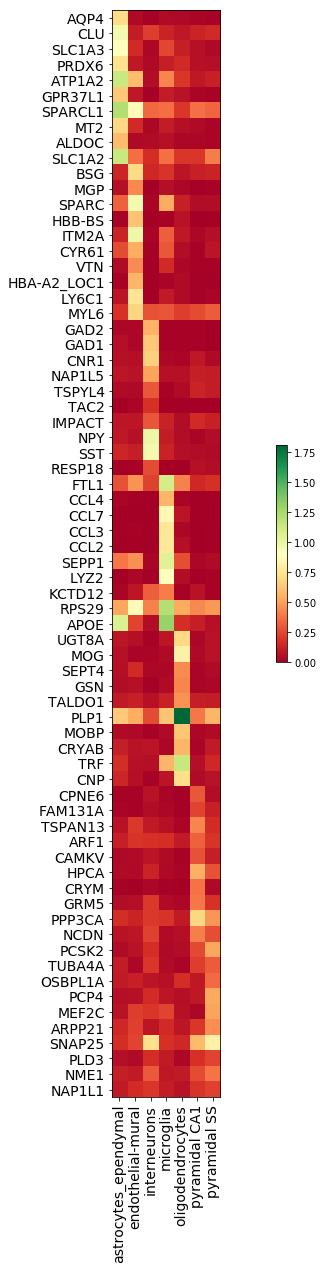

In [17]:
plt.figure(figsize=(20, 20))
im = plt.imshow(expression, cmap='RdYlGn', interpolation='none', aspect='equal')
ax = plt.gca()
ax.set_xticks(np.arange(0, 7, 1))
ax.set_xticklabels(gene_dataset.cell_types, rotation='vertical')
ax.set_yticklabels(genes)
ax.set_yticks(np.arange(0, 70, 1))
ax.tick_params(labelsize=14)
plt.colorbar(shrink=0.2)

## Logging information

Verbosity varies in the following way:
* `logger.setLevel(logging.WARNING)` will show a progress bar.
* `logger.setLevel(logging.INFO)` will show global logs including the number of jobs done.
* `logger.setLevel(logging.DEBUG)` will show detailed logs for each training (e.g the parameters tested).

This function's behaviour can be customized, please refer to its documentation for information about the different parameters available.

In general, you can use `scvi.set_verbosity(level)` to set the verbosity of the scvi package.
Note that `level` corresponds to the logging levels of the standard python `logging` module. By default, that level is set to `INFO` (=20).
As a reminder the logging levels are:
<table class="docutils align-center">
<colgroup>
<col style="width: 48%">
<col style="width: 52%">
</colgroup>
<thead>
<tr class="row-odd"><th class="head"><p>Level</p></th>
<th class="head"><p>Numeric value</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">CRITICAL</span></code></p></td>
<td><p>50</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">ERROR</span></code></p></td>
<td><p>40</p></td>
</tr>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">WARNING</span></code></p></td>
<td><p>30</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">INFO</span></code></p></td>
<td><p>20</p></td>
</tr>
<tr class="row-even"><td><p><code class="docutils literal notranslate"><span class="pre">DEBUG</span></code></p></td>
<td><p>10</p></td>
</tr>
<tr class="row-odd"><td><p><code class="docutils literal notranslate"><span class="pre">NOTSET</span></code></p></td>
<td><p>0</p></td>
</tr>
</tbody>
</table>

In [ ]:
### UTIL : Conda clo